In [8]:
# Import libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv("BankChurn.csv")

In [10]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [11]:
df = df.drop(columns = ["CLIENTNUM", "Attrition_Flag"])

In [12]:
# 1. Preprocessing
# Define numerical and categorical features
num_features = ['Customer_Age', 'Dependent_count', 'Months_on_book', 
                'Total_Relationship_Count', 'Months_Inactive_12_mon',
                'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

cat_features = ['Gender', 'Education_Level', 'Marital_Status', 
                'Income_Category', 'Card_Category']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Transform data
X_processed = preprocessor.fit_transform(df)

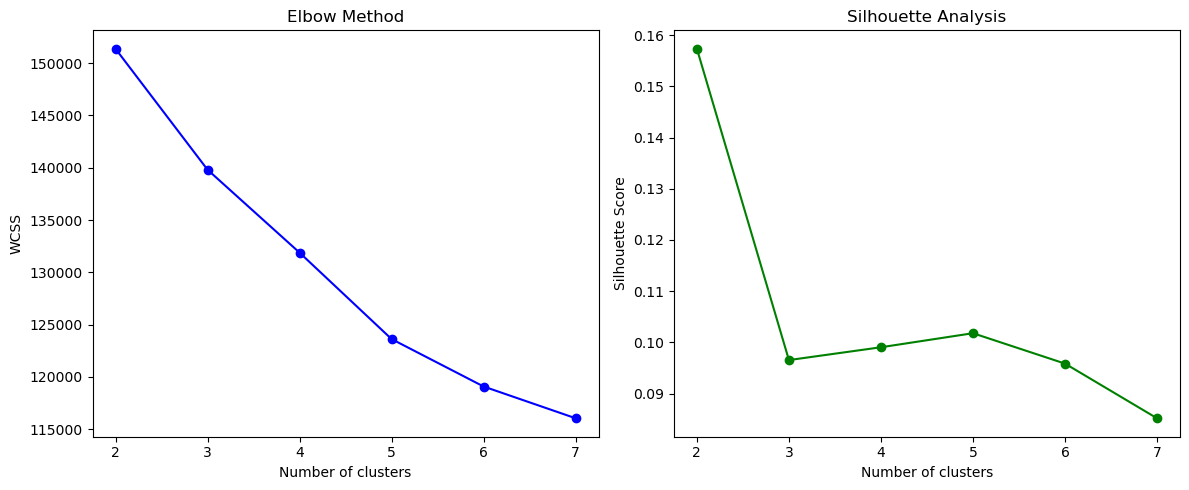

In [13]:
# 2. Determine optimal number of clusters
wcss = []
silhouette_scores = []
cluster_range = range(2, 8)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_processed, kmeans.labels_))

# Plot elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, wcss, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

In [14]:
# 3. Fit final K-means model
optimal_clusters = 3  # Change based on your plots
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_processed)


Cluster Characteristics:
         Customer_Age  Dependent_count  Months_on_book  \
Cluster                                                  
0           46.113472         2.312596       35.616867   
1           46.669722         2.305473       36.377191   
2           46.161360         2.510523       35.797625   

         Total_Relationship_Count  Months_Inactive_12_mon  \
Cluster                                                     
0                        3.871194                2.287404   
1                        3.956862                2.431383   
2                        3.379385                2.293038   

         Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
Cluster                                                             
0                     2.336035   3913.298970          1685.870537   
1                     2.632785   6329.813777           473.117822   
2                     2.393956  24864.709120          1254.735564   

         Avg_Open_To_Buy  Total

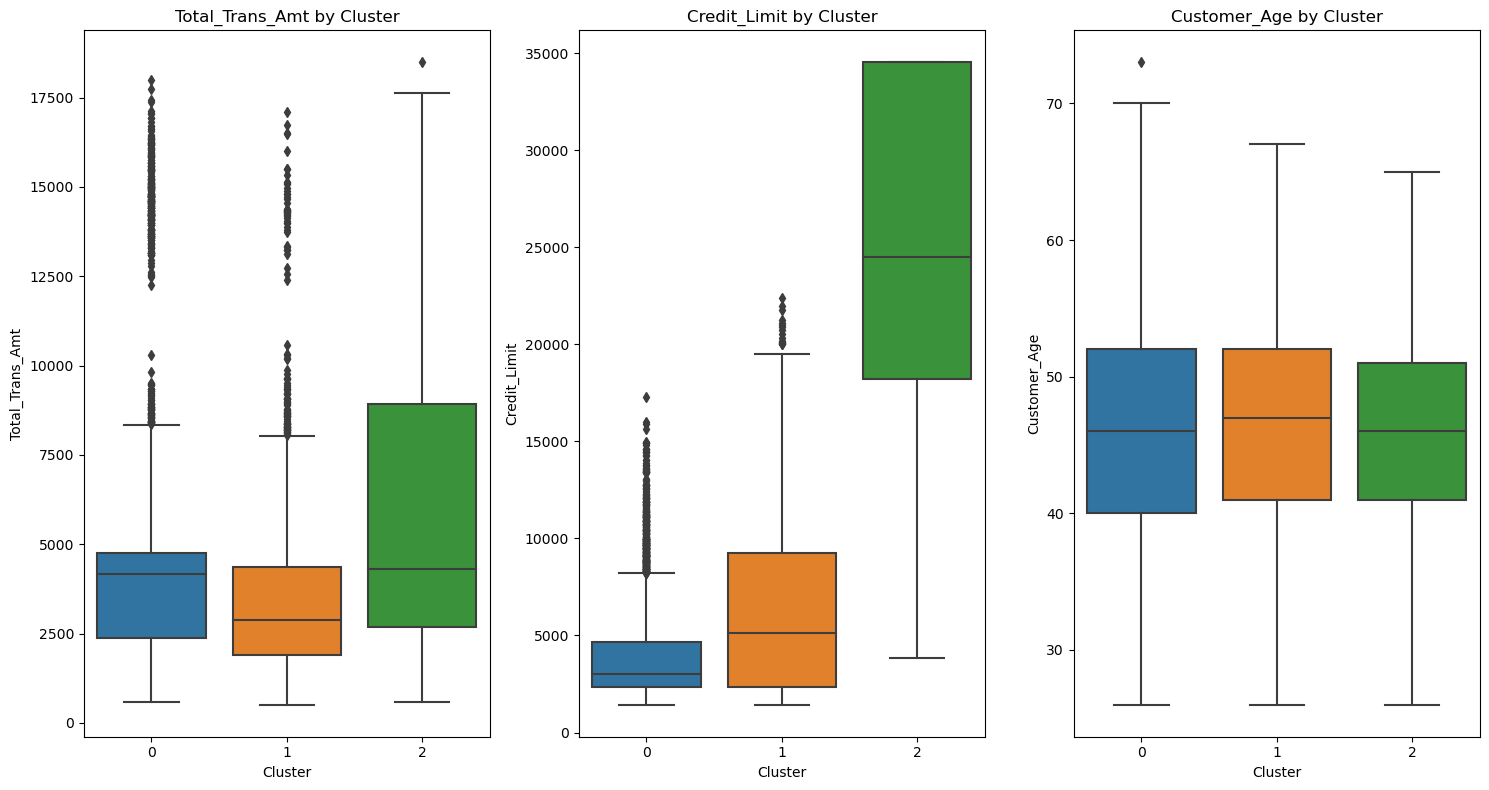

In [15]:
# 4. Analyze clusters
df['Cluster'] = clusters

# Cluster statistics
cluster_stats = df.groupby('Cluster').mean(numeric_only=True)
print("\nCluster Characteristics:")
print(cluster_stats)

# Visualize key features by cluster
plt.figure(figsize=(15, 8))
for i, feature in enumerate(['Total_Trans_Amt', 'Credit_Limit', 'Customer_Age'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

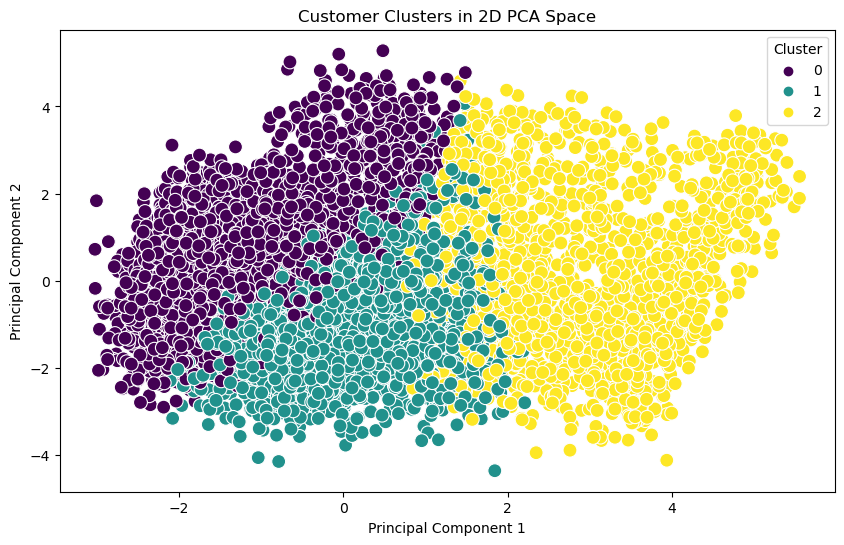

In [16]:
# 5. Advanced visualization (PCA for 2D projection)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('Customer Clusters in 2D PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()